Compare Claire's NSA (w/ extra value added) to SFRs of the MPA-JHU catalog

In [1]:
import h5py
import numpy as np
from astropy.io import fits
from astropy import units as U
from pydl.pydlutils.spheregroup import spherematch
# -- iQuench -- 
from letstalkaboutquench import util as UT

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in Claire's low mass *value added* central (isolated) catalog 

In [3]:
claire = h5py.File(''.join([UT.dat_dir(), 'dickey_NSA_iso_lowmass_gals.valueadd.hdf5']), 'r') 

In [4]:
n_claire = len(claire['RA'].value)
print('%i galaxies in Claires catalog' % n_claire)

14998 galaxies in Claires catalog


Read in MPA-JHU catalogs

In [44]:
f_mpa_gal = fits.open(''.join([UT.dat_dir(), 'gal_info_dr7_v5_2.fit.gz']))
f_mpa_fibsfr = fits.open(''.join([UT.dat_dir(), 'gal_fibsfr_dr7_v5_2.fits.gz']))
f_mpa_totsfr = fits.open(''.join([UT.dat_dir(), 'gal_totsfr_dr7_v5_2.fits.gz']))

In [45]:
mpa_gal = f_mpa_gal[1].data
mpa_fibsfr = f_mpa_fibsfr[1].data
mpa_totsfr = f_mpa_totsfr[1].data

In [7]:
assert len(mpa_gal['ra']) == len(mpa_fibsfr['avg'])

In [8]:
# some of the ra and dec values are garbage
cut = (mpa_gal['ra'] != -9999.) & (mpa_gal['dec'] != -9999.)

In [9]:
print('%i galaxies in the MPAJHU catalog' % np.sum(cut))

927551 galaxies in the MPAJHU catalog


(-20, 90.0)

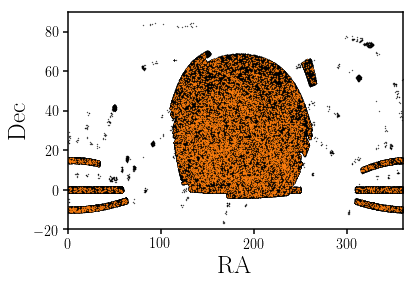

In [10]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(mpa_gal['ra'][cut], mpa_gal['dec'][cut], c='k', s=0.1)
sub.scatter(claire['RA'].value, claire['DEC'].value, c='C1', s=0.1)
sub.set_xlabel('RA', fontsize=25)
sub.set_xlim([0., 360.])
sub.set_ylabel('Dec', fontsize=25)
sub.set_ylim([-20, 90.])

Now lets spherematch the two 

In [11]:
match_length  = (3 * U.arcsec).to(U.degree)
print('match length = %f degrees'% match_length.value)

match length = 0.000833 degrees


In [12]:
# now lets spherematch the two
m_mpa, m_claire, dmatch = spherematch(mpa_gal['ra'][cut], mpa_gal['dec'][cut], claire['RA'].value, claire['DEC'].value, 
                                      match_length.value, maxmatch=0)

In [19]:
m_claire_uniq, uniq_indices = np.unique(m_claire, return_index=True)

In [23]:
ra_claire_uniq = claire['RA'].value[m_claire_uniq]
dec_claire_uniq = claire['DEC'].value[m_claire_uniq]
z_claire_uniq = claire['Z'].value[m_claire_uniq]

In [24]:
ra_mpa_match = mpa_gal['RA'][cut][m_mpa]
dec_mpa_match = mpa_gal['DEC'][cut][m_mpa]
z_mpa_match = mpa_gal['Z'][cut][m_mpa]

In [26]:
m_mpa_uniq = []
for i_uniq in range(len(m_claire_uniq)): 
    match_i = (m_claire == m_claire_uniq[i_uniq])

    ra_claire = ra_claire_uniq[i_uniq]
    dec_claire = dec_claire_uniq[i_uniq]
    z_claire = z_claire_uniq[i_uniq]
    
    ra_mpa = ra_mpa_match[match_i]
    dec_mpa = dec_mpa_match[match_i]
    z_mpa = z_mpa_match[match_i]
    
    if np.sum(match_i) == 1: 
        if np.abs(z_mpa - z_claire) < 0.001: 
            m_mpa_uniq.append(m_mpa[match_i][0])
        else: 
            print ra_claire, dec_claire, z_claire
            print ra_mpa, dec_mpa, z_mpa
    elif np.sum(match_i) > 1: 
        dz = z_mpa - z_claire
        i_dz_min = np.argmin(np.abs(dz))
        if dz[i_dz_min] < 0.001: 
            m_mpa_uniq.append(m_mpa[match_i][i_dz_min])
        else: 
            print ra_claire, dec_claire, z_claire
            print ra_mpa, dec_mpa, z_mpa
    i += 1
m_mpa_uniq = np.array(m_mpa_uniq)

In [43]:
print('%i galaxies out of %i in the NSA have matches' % (len(m_claire_uniq), n_claire))

14982 galaxies out of 14998 in the NSA have matches


In [30]:
assert np.min(claire['Z'].value[m_claire_uniq] - mpa_gal['Z'][cut][m_mpa_uniq]) < 1e-4

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(-4.0, 2.0)

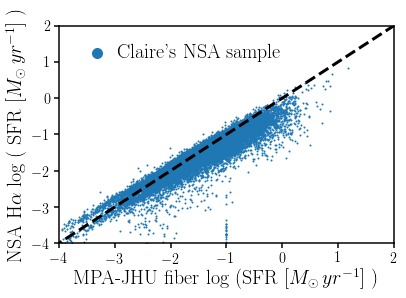

In [42]:
fig = plt.figure() 
sub = fig.add_subplot(111)
sub.scatter(mpa_fibsfr['MEDIAN'][cut][m_mpa_uniq], np.log10(claire['HASFR'].value[m_claire_uniq]), c='C0', s=1, 
            label="Claire's NSA sample") 
sub.plot([-10., 10.], [-10., 10.], c='k', ls='--', lw=3)
sub.legend(loc='upper left', markerscale=10, handletextpad=0., prop={'size':20})
sub.set_xlabel(r'MPA-JHU fiber log (SFR $[M_\odot \, yr^{-1}]$ )', fontsize=20)
sub.set_xlim([-4.,2.])
sub.set_ylabel(r'NSA H$\alpha$ log ( SFR $[M_\odot \, yr^{-1}]$ )', fontsize=20)
sub.set_ylim([-4.,2.])

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(-4.0, 2.0)

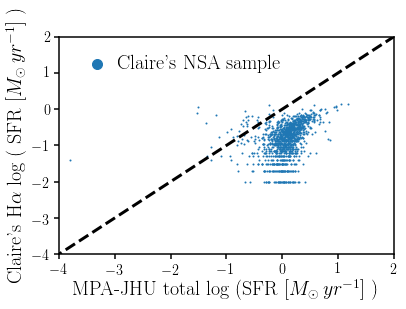

In [48]:
fig = plt.figure() 
sub = fig.add_subplot(111)
sub.scatter(mpa_totsfr['AVG'][cut][m_mpa_uniq], np.log10(claire['HALPHA_SFR_claire'].value[m_claire_uniq]), c='C0', s=1, 
            label="Claire's NSA sample") 
sub.plot([-10., 10.], [-10., 10.], c='k', ls='--', lw=3)
sub.legend(loc='upper left', markerscale=10, handletextpad=0., prop={'size':20})
sub.set_xlabel(r'MPA-JHU total log (SFR $[M_\odot \, yr^{-1}]$ )', fontsize=20)
sub.set_xlim([-4.,2.])
sub.set_ylabel(r"Claire's H$\alpha$ log ( SFR $[M_\odot \, yr^{-1}]$ )", fontsize=20)
sub.set_ylim([-4.,2.])

/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


(-4.0, 2.0)

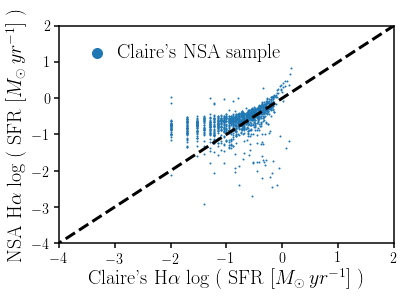

In [50]:
fig = plt.figure() 
sub = fig.add_subplot(111)
sub.scatter(np.log10(claire['HALPHA_SFR_claire'].value[m_claire_uniq]), np.log10(claire['HASFR'].value[m_claire_uniq]), c='C0', s=1, 
            label="Claire's NSA sample") 
sub.plot([-10., 10.], [-10., 10.], c='k', ls='--', lw=3)
sub.legend(loc='upper left', markerscale=10, handletextpad=0., prop={'size':20})
sub.set_ylabel(r'NSA H$\alpha$ log ( SFR $[M_\odot \, yr^{-1}]$ )', fontsize=20)
sub.set_xlim([-4.,2.])
sub.set_xlabel(r"Claire's H$\alpha$ log ( SFR $[M_\odot \, yr^{-1}]$ )", fontsize=20)
sub.set_ylim([-4.,2.])